In [1]:
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision.utils import make_grid
from torchvision import transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
transforms = T.Compose([T.RandomHorizontalFlip(),
                        T.ToTensor(),
                        T.Normalize(*stats)])

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Train dataset
train = torchvision.datasets.CIFAR10(download = True, root = '../data',
                                     train = True, transform = transforms)
train_dl = DataLoader(train, num_workers = 3, batch_size = 64, shuffle = True)

### Test dataset
test = torchvision.datasets.CIFAR10(download = True, root = '../data',
                                   train = False, transform = transforms)

test_dl = DataLoader(test, num_workers = 3, batch_size = 64, shuffle = True)

### Data labels
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

0it [00:00, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [3]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

In [4]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [5]:
device

device(type='cuda', index=0)

torch.Size([64, 3, 32, 32])


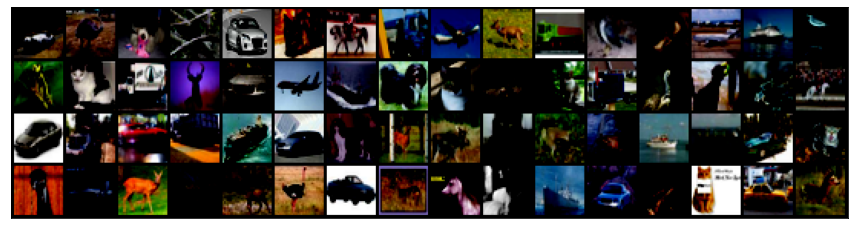

In [6]:
### Visualizing a data batch
for batch in train_dl:
    print(batch[0].shape)
    plt.figure(figsize = (15, 8))
    plt.imshow(make_grid(tensor = batch[0].detach(), nrow = 16).permute(1, 2, 0))
    plt.xticks([]); plt.yticks([])
    plt.show()
    break

In [7]:
### Network class
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size = 5, stride = 1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size = 5, stride = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.linear1 = nn.Linear(16 * 5 * 5, 120)
        self.drop = nn.Dropout(0.3)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, 10)
        
    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = self.pool(y)
        y = F.relu(self.conv2(y))
        y = self.pool(y)
        
        y = torch.flatten(y, 1)
        y = F.relu(self.linear1(y))
        y = self.drop(y)
        y = F.relu(self.linear2(y))
        y = self.drop(y)
        y = self.linear3(y)
        return y

In [8]:
### Instantiating network and training
model = MyCNN()
model.to(device)

train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4, weight_decay = 0.0001)

correct = 0
total = 0

for epoch in range(20):
    for batch, labels in train_dl:
        optimizer.zero_grad()
        pred = model(batch)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        _, predictions = torch.max(pred.data, 1)
        correct += (predictions == labels).sum().item()
        total += len(batch)
    print(f'Epoch {epoch + 1}, loss: {round(loss.item(), 4)}')
    print('--'*50)
print(f'Train Accuracy: {correct/total}')

Epoch 1, loss: 1.5744
----------------------------------------------------------------------------------------------------
Epoch 2, loss: 1.358
----------------------------------------------------------------------------------------------------
Epoch 3, loss: 1.4079
----------------------------------------------------------------------------------------------------
Epoch 4, loss: 1.3206
----------------------------------------------------------------------------------------------------
Epoch 5, loss: 1.0635
----------------------------------------------------------------------------------------------------
Epoch 6, loss: 1.1873
----------------------------------------------------------------------------------------------------
Epoch 7, loss: 1.5427
----------------------------------------------------------------------------------------------------
Epoch 8, loss: 1.0659
----------------------------------------------------------------------------------------------------
Epoch 9, loss: 1.

In [9]:
### Testing
total = 0
correct = 0

with torch.no_grad():
    for batch, labels in test_dl:
        outputs = model(batch)
        _, predictions = torch.max(outputs.data, 1)
        correct += (predictions == labels).sum().item()
        total += len(batch)

In [10]:
correct/total

0.5985

**Attempting to use a pre-trained model (VGG-16)**

In [11]:
from torchvision.models import vgg16

In [12]:
### Instantiating pretrained model
vgg_model = vgg16(pretrained = True)
vgg_model.classifier[6].out_features = 10
vgg_model.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
### Training and train performance

criterion = nn.CrossEntropyLoss()

#for param in vgg_model.parameters():
    #param.requires_grad = False
    
optimizer = torch.optim.Adam(vgg_model.parameters(), lr = 1e-4, weight_decay = 0.01)

correct = 0
total = 0

for epoch in range(20):
    for batch, labels in train_dl:
        optimizer.zero_grad()
        pred = vgg_model(batch)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        _, predictions = torch.max(pred.data, 1)
        correct += (predictions == labels).sum().item()
        total += len(batch)
    print(f'Epoch {epoch + 1}, loss: {round(loss.item(), 4)}')
    print('--'*50)
print(f'Train Accuracy: {correct/total}')

Epoch 1, loss: 0.9599
----------------------------------------------------------------------------------------------------
Epoch 2, loss: 0.5338
----------------------------------------------------------------------------------------------------
Epoch 3, loss: 0.4216
----------------------------------------------------------------------------------------------------
Epoch 4, loss: 0.4249
----------------------------------------------------------------------------------------------------
Epoch 5, loss: 0.6999
----------------------------------------------------------------------------------------------------
Epoch 6, loss: 0.4351
----------------------------------------------------------------------------------------------------
Epoch 7, loss: 0.1717
----------------------------------------------------------------------------------------------------
Epoch 8, loss: 0.4128
----------------------------------------------------------------------------------------------------
Epoch 9, loss: 0

In [14]:
### Test performance
total = 0
correct = 0

with torch.no_grad():
    for batch, labels in test_dl:
        outputs = vgg_model(batch)
        _, predictions = torch.max(outputs.data, 1)
        correct += (predictions == labels).sum().item()
        total += len(batch)
    print(f'Test Accuracy: {correct/total}')

Test Accuracy: 0.8498
